In [1]:
import sys, os
from pathlib import Path
sys.path.append(os.path.abspath(Path().resolve().parent/'src'))


from kinematicsrobotics.model import Cluster
from kinematicsrobotics.datahandler import Save, Extract

In [2]:
ext = Extract()
ext._path_project = os.path.abspath(Path().resolve().parent)
#dataset = ext.dataframe(r'src\data\raw\dataset-semi-raw.csv')
dataset = ext.dataframe(r'src\data\ready\dataset-radius-0.5cm.csv')
dataset.shape

(15324, 11)

In [3]:
kmeans = Cluster(data = dataset[['p_x','p_y','p_z']], 
                n_clusters = 4, 
                n_init = 'auto'
)

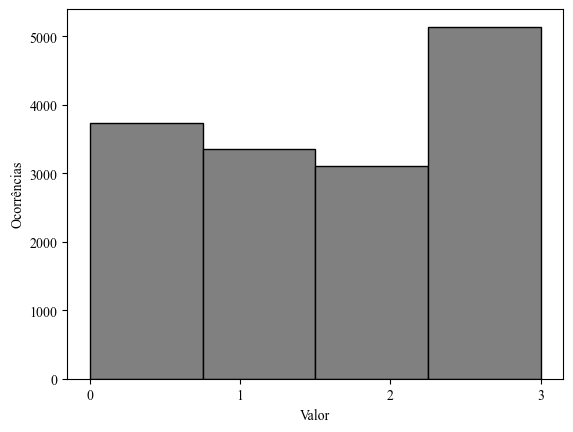

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.rcParams["font.family"] = "Times New Roman"
plt.hist(kmeans._model.labels_, bins=4, color='gray', edgecolor='black')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# Adicionar título e rótulos

plt.xlabel("Valor")
plt.ylabel("Ocorrências")

# Exibir o gráfico
plt.show()


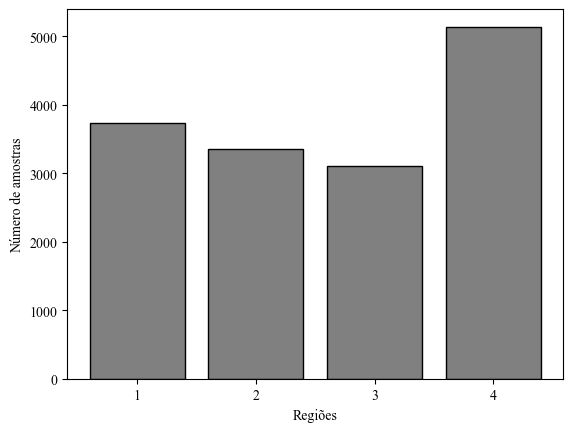

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# Definir estilo da fonte
plt.rcParams["font.family"] = "Times New Roman"

# Contar a frequência de cada cluster
clusters, counts = np.unique(kmeans._model.labels_, return_counts=True)

# Criar gráfico de barras
plt.bar(clusters+1, counts, color='gray', edgecolor='black')

# # Adicionar título e rótulos
# plt.title('Distribuição dos Clusters', fontsize=14)
plt.xlabel('Regiões')
plt.ylabel('Número de amostras')

# Forçar o eixo x a ser inteiro
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Exibir o gráfico
plt.show()

In [12]:
from kinematicsrobotics.model import Model
from kinematicsrobotics.model import Cluster
from kinematicsrobotics.datahandler import Save, Extract
from kinematicsrobotics.dataprocessing import Preprocessing

class LocalModel:
    def __init__(self, *, model_cluster: Cluster, data, **kw):
        self._model_cluster = model_cluster
        self.models(**kw)
        self.clusters(data = data)
    
    
    def models(self, **kw):
        models = []
        for k in self._model_cluster._class_cluster:
            models.append(Model.mlp_regressor(**kw))
        
        self._models = models
    
    def set_model(self,**params):
        for model in self._models:
            model.set_model(**params)

    def fit(self):
        i = 0
        for model in self._models:
            x_train, x_test, y_train, y_test = self._data_processing[i].data_train_test
            model.fit(x = x_train, y = y_train)
            i +=1

    def clusters(self, data):
        clusteres = set(self._model_cluster._model.labels_)
        data_clusters = []
        for cluster in clusteres:
            idex_labes = []
            i = 0
            for labels in self._model_cluster._model.labels_:
                if labels == cluster:
                    idex_labes.append(i)
                i +=1
            data_clusters.append(data.iloc[idex_labes])

        self._data_clusters = data_clusters


    def split(self, *, test_size = 0.1):
        data_processing = []
        for cluster in self._data_clusters:
            data_processing.append(Preprocessing(dataset = cluster, 
                                    x_labels=['p_x', 'p_y','p_z', 'roll', 'pich', 'yaw'],
                                    y_labels=['theta_1', 'theta_2', 'theta_3', 'theta_4'], 
                                    size_test = test_size
                                    )
            )
        self._data_processing = data_processing
            

    # def predict(self,*, x):
    #     return self._model.predict(x)

In [13]:
mlps = LocalModel(model_cluster=kmeans,
                  data = dataset,
                  early_stopping=True, 
                  EPOCHS=1000, 
                  EPOCHS_NOCHANGE=30,
                  random_state=42, 
                  verbose=True,
                  hidden_layer_sizes = (320, 375, 265, 155),
                  activation = 'relu'
                  )

In [22]:
mlps.split(test_size=0.1)

In [23]:
mlps.fit()

Iteration 1, loss = 0.26721924
Validation score: 0.726978
Iteration 2, loss = 0.09832550
Validation score: 0.884006
Iteration 3, loss = 0.04930091
Validation score: 0.916110
Iteration 4, loss = 0.03734662
Validation score: 0.931893
Iteration 5, loss = 0.03142666
Validation score: 0.939404
Iteration 6, loss = 0.02874499
Validation score: 0.944759
Iteration 7, loss = 0.02501841
Validation score: 0.949721
Iteration 8, loss = 0.02015677
Validation score: 0.958138
Iteration 9, loss = 0.01949248
Validation score: 0.960066
Iteration 10, loss = 0.01819495
Validation score: 0.962298
Iteration 11, loss = 0.01711219
Validation score: 0.957404
Iteration 12, loss = 0.01763767
Validation score: 0.963673
Iteration 13, loss = 0.01509610
Validation score: 0.956349
Iteration 14, loss = 0.01677429
Validation score: 0.966714
Iteration 15, loss = 0.01448118
Validation score: 0.969954
Iteration 16, loss = 0.01277095
Validation score: 0.968657
Iteration 17, loss = 0.01349441
Validation score: 0.963431
Iterat

In [57]:
mlps._models[3]._model.loss_

0.00034571466991975406

0.0021319917287944026
0.000665576399602167
0.000977069887152703
0.00034571466991975406

Text(0, 0.5, 'MSE')

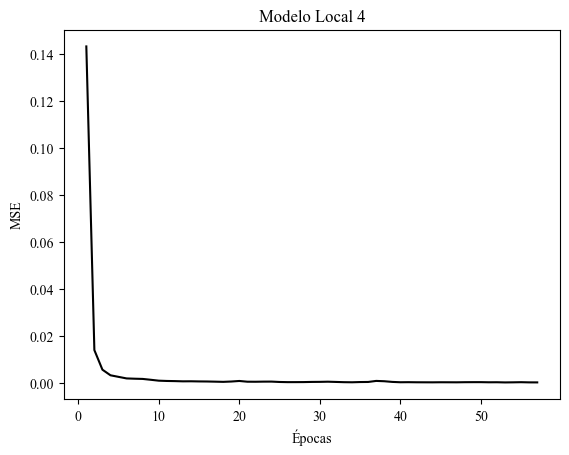

In [28]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

n = 4
loss = mlps._models[n-1]._model.loss_curve_

plt.plot(range(1,len(loss)+1), loss, color='black')
plt.title(f"Modelo Local {n}")
plt.xlabel("Épocas")
plt.ylabel("MSE")



### Métricas

In [36]:
from pandas import DataFrame

In [30]:
from kinematicsrobotics.kinematics import Robo
from kinematicsrobotics.metrics import Metrics
Elos = [['theta_1',10,0,90,0],
        ['theta_2',0,18,180,0],
        ['theta_3',0,18,-180,0],
        ['theta_4',0,0,90,90],
        ['theta_5',18,0,0,0]
]

robo = Robo("Robo", Elos)


#### modelo local 1

In [ ]:
metric = Metrics(model = mlps._models[0],
                 scaler_x = mlps._data_processing[0]._scaler_x , 
                 scaler_y = mlps._data_processing[0]._scaler_y,
                 robo=robo)

In [32]:
x_train, x_test, y_train, y_test = mlps._data_processing[0].data_train_test

In [37]:
DataFrame({'MSE Treino': metric.mse_joint(x = x_train, y=y_train),
           'MSE Teste': metric.mse_joint(x = x_test, y=y_test)
           }
)


,MSE Treino,MSE Teste
0,0.341584,0.307762
1,1.634363,0.572210
2,4.625524,2.011479
3,1.296714,0.830990


In [38]:
DataFrame({'MSE Treino': metric.mse_operacional(x=x_train),
           'MSE Teste': metric.mse_operacional(x=x_test)
           }
)

,MSE Treino,MSE Teste
0,0.038146,0.042922
1,0.031504,0.034181
2,0.024590,0.024977


#### Modelo 2

In [39]:
metric = Metrics(model = mlps._models[1],
                 scaler_x = mlps._data_processing[1]._scaler_x , 
                 scaler_y = mlps._data_processing[1]._scaler_y,
                 robo=robo)

x_train, x_test, y_train, y_test = mlps._data_processing[1].data_train_test

In [40]:
DataFrame({'MSE Treino': metric.mse_joint(x = x_train, y=y_train),
           'MSE Teste': metric.mse_joint(x = x_test, y=y_test)
           }
)

,MSE Treino,MSE Teste
0,0.054834,0.063672
1,0.787557,0.795459
2,1.803722,1.862380
3,1.677166,2.108314


In [41]:
DataFrame({'MSE Treino': metric.mse_operacional(x=x_train),
           'MSE Teste': metric.mse_operacional(x=x_test)
           }
)

,MSE Treino,MSE Teste
0,0.026105,0.028144
1,0.022211,0.024107
2,0.058474,0.060900


#### Modelo 2

In [43]:
metric = Metrics(model = mlps._models[2],
                 scaler_x = mlps._data_processing[2]._scaler_x , 
                 scaler_y = mlps._data_processing[2]._scaler_y,
                 robo=robo)

x_train, x_test, y_train, y_test = mlps._data_processing[2].data_train_test


In [44]:
DataFrame({'MSE Treino': metric.mse_joint(x = x_train, y=y_train),
           'MSE Teste': metric.mse_joint(x = x_test, y=y_test)
           }
)

,MSE Treino,MSE Teste
0,0.068702,0.054316
1,0.553780,0.421493
2,1.574272,1.054620
3,0.648077,0.543786


In [45]:
DataFrame({'MSE Treino': metric.mse_operacional(x=x_train),
           'MSE Teste': metric.mse_operacional(x=x_test)
           }
)

,MSE Treino,MSE Teste
0,0.030883,0.027069
1,0.023531,0.019502
2,0.078293,0.063161


#### Modelo 4


In [46]:
metric = Metrics(model = mlps._models[3],
                 scaler_x = mlps._data_processing[3]._scaler_x , 
                 scaler_y = mlps._data_processing[3]._scaler_y,
                 robo=robo)

x_train, x_test, y_train, y_test = mlps._data_processing[3].data_train_test

In [47]:
DataFrame({'MSE Treino': metric.mse_joint(x = x_train, y=y_train),
           'MSE Teste': metric.mse_joint(x = x_test, y=y_test)
           }
)

,MSE Treino,MSE Teste
0,0.254326,0.259120
1,0.135233,0.142561
2,0.264624,0.242278
3,0.452105,0.598001


In [48]:
DataFrame({'MSE Treino': metric.mse_operacional(x=x_train),
           'MSE Teste': metric.mse_operacional(x=x_test)
           }
)

,MSE Treino,MSE Teste
0,0.021187,0.022199
1,0.030333,0.029449
2,0.019281,0.018123
